# Exercise Session - Non Linear Dimensionality Reduction

We will explore **Autoencoder** for non linear dimensionality reduction. **Pytorch** will be used in this exercise, which can be reviewed in the previous exercises.

In [1]:
# import a few packages
%matplotlib inline
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
import os

# Convolutional Autoencoder
In the lecture, we learn about the concept of a non-linear encoder/decoder architecture, namely the convolutional autoencoder. An encoder $f_{e}$ first encodes the input $x$ into a feature $z$ and then this feature vector is decoded back to the input image by a decoder $f_{d}$, this process is defined as

$$
\begin{align*}
z = f_{e}(x) \\
\hat{x} = f_{d}(z)
\end{align*}
$$

The parameters in the autodecoder can be computed by minimizing the MSE loss:

$$
\begin{align*}
\sum_n \lVert \hat{x_n} - x_n \rVert ^2 \\
\end{align*}
$$


We will use the **Conv2d** and **ConvTranspose2d** in pytorch to define our convolutional autoencoder in this exercise.

## MNIST 

We first begin with a simple dataset -- MNIST which consists of gray images. In the training process, we visualize both the reconstructed image $\hat{x}$ and the grayscaled encoded feature $z$ every 5 epoches, you could find the output pictures of last training batch in the folder named "mnist_vis". 


In [24]:
# define the mnist autoencoder network
class autoencoder_mnist(nn.Module):
    '''
    Input size (1, 28, 28), then filling each layer according to its output size
    
    arg: d: int, the channel size of encoded feature
    
    '''
    def __init__(self, d=8):
        super(autoencoder_mnist, self).__init__()
        '''
        Define an encoder with 3 convolutional layers with kernel size of 3, padding=1, 
        each one followed by a ReLU layer and a MaxPooling layer.
        That is: 3 × (Conv2d --> ReLU --> MaxPool2d)
        
        Hint: use stride in pooling layers to reduce output size
        
        '''
        self.encoder = nn.Sequential(
            ### CODE HERE ###
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (16, 14, 14)
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (8, 7, 7)
            nn.Conv2d(8, d, kernel_size=3, stride=1, padding=1),  # (d, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d(2) # (d, 3, 3)
        )
        '''
        Define a decoder with 3 transposed convolutional layers. The first two of them are followed by a ReLU layer.
        That is: 2 × (ConvTranspose2d --> ReLU ) --> ConvTranspose2d 
        
        Hint: use stride and proper kernel size to reconstruct the output size.
        
        '''
        self.decoder = nn.Sequential(
            ### CODE HERE ###
            nn.ConvTranspose2d(d, 8, kernel_size=3 ,stride=2),   # (8, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),  # (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)   # (1, 28, 28)
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)    
        return x,z

Epoch [1/50], Training loss:0.2160


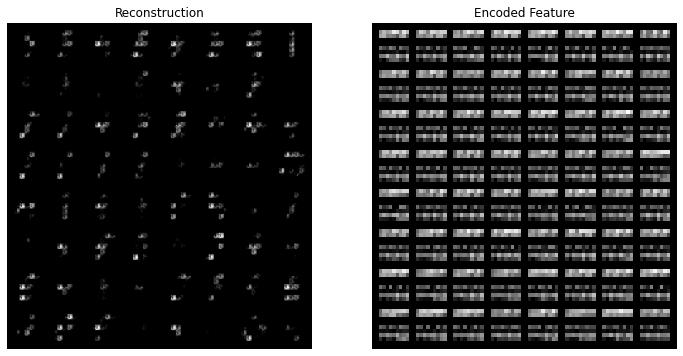

Epoch [2/50], Training loss:0.1573
Epoch [3/50], Training loss:0.1348
Epoch [4/50], Training loss:0.1428
Epoch [5/50], Training loss:0.1169


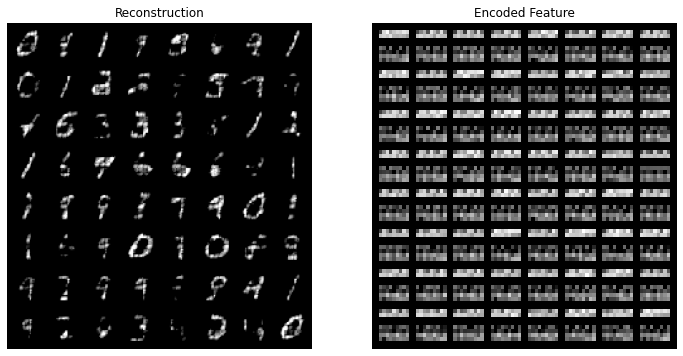

Epoch [6/50], Training loss:0.1288
Epoch [7/50], Training loss:0.1161
Epoch [8/50], Training loss:0.1221
Epoch [9/50], Training loss:0.1117
Epoch [10/50], Training loss:0.1072


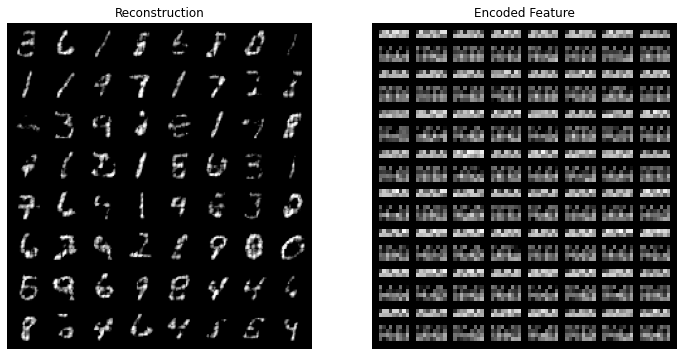

Epoch [11/50], Training loss:0.1173
Epoch [12/50], Training loss:0.1064
Epoch [13/50], Training loss:0.1069
Epoch [14/50], Training loss:0.1110
Epoch [15/50], Training loss:0.1075


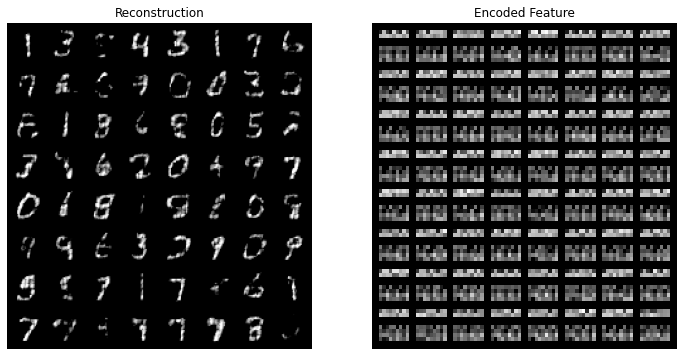

Epoch [16/50], Training loss:0.0994
Epoch [17/50], Training loss:0.0880
Epoch [18/50], Training loss:0.1027
Epoch [19/50], Training loss:0.0963
Epoch [20/50], Training loss:0.1004


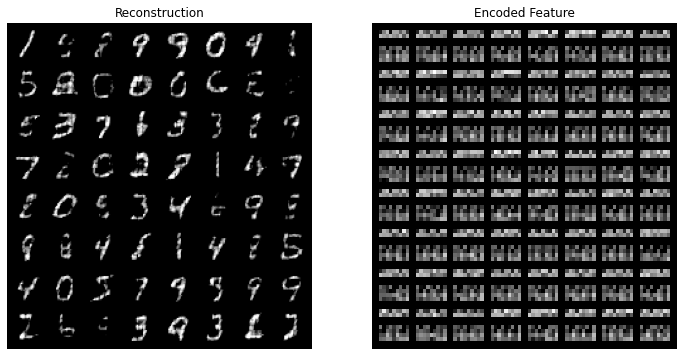

Epoch [21/50], Training loss:0.1056
Epoch [22/50], Training loss:0.0979
Epoch [23/50], Training loss:0.0966
Epoch [24/50], Training loss:0.1016
Epoch [25/50], Training loss:0.1023


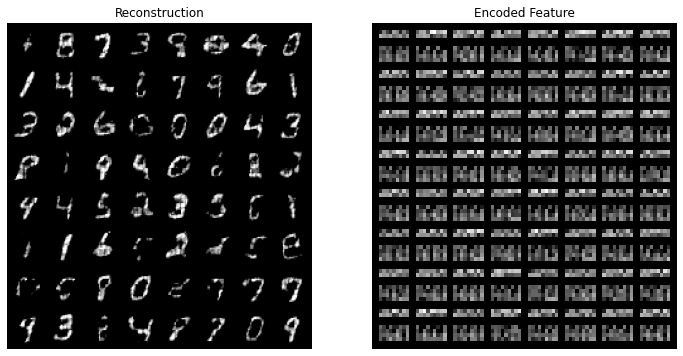

Epoch [26/50], Training loss:0.0939
Epoch [27/50], Training loss:0.0931
Epoch [28/50], Training loss:0.0908
Epoch [29/50], Training loss:0.0898
Epoch [30/50], Training loss:0.1049


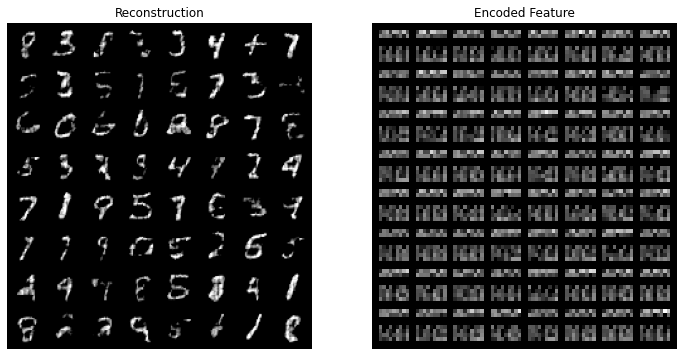

Epoch [31/50], Training loss:0.0780
Epoch [32/50], Training loss:0.0939
Epoch [33/50], Training loss:0.0939
Epoch [34/50], Training loss:0.0855
Epoch [35/50], Training loss:0.0880


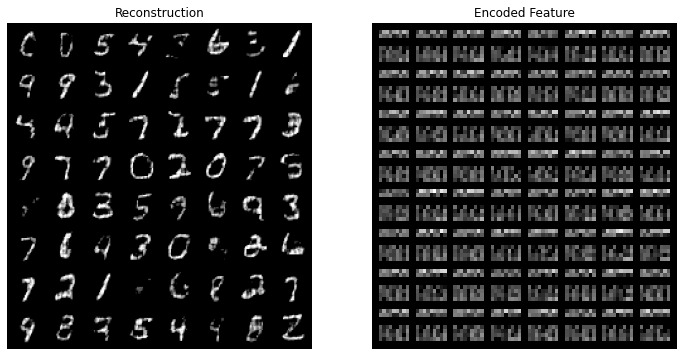

Epoch [36/50], Training loss:0.0905
Epoch [37/50], Training loss:0.0919
Epoch [38/50], Training loss:0.0808
Epoch [39/50], Training loss:0.0879
Epoch [40/50], Training loss:0.1004


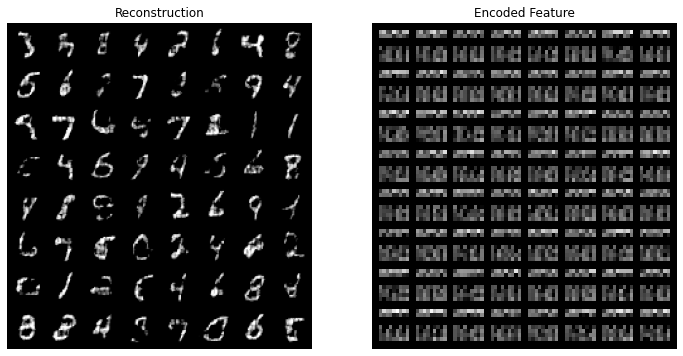

Epoch [41/50], Training loss:0.0762
Epoch [42/50], Training loss:0.0936
Epoch [43/50], Training loss:0.0891
Epoch [44/50], Training loss:0.0955
Epoch [45/50], Training loss:0.0851


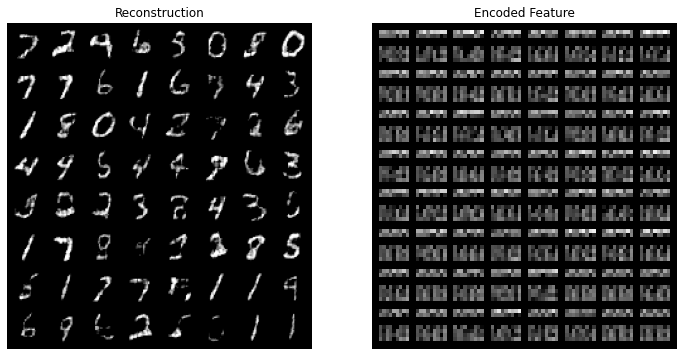

Epoch [46/50], Training loss:0.0750
Epoch [47/50], Training loss:0.0784
Epoch [48/50], Training loss:0.0800
Epoch [49/50], Training loss:0.0838
Epoch [50/50], Training loss:0.0839


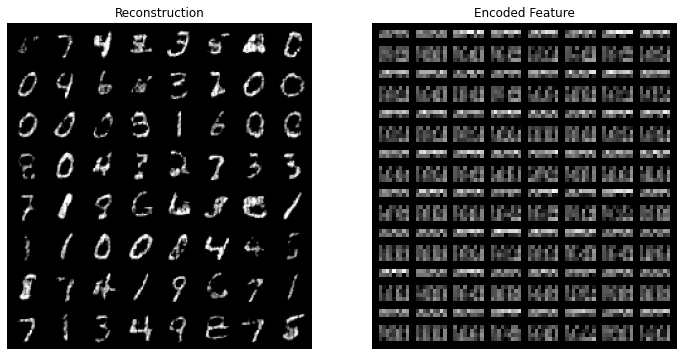

Finished.


In [25]:
# define the folder to save the visualization pictures
if not os.path.exists('./mnist_vis'):
    os.mkdir('./mnist_vis/')
    os.mkdir('./mnist_vis/reconstruction/')
    os.mkdir('./mnist_vis/feature/')


# define the hyper-parameters
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

# get the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, ), (0.5, )),
                             ])


dataset = MNIST('mnist_data/', download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64,num_workers=4, sampler=SubsetRandomSampler(range(12800)))

# define a model and criterion
model = autoencoder_mnist()
### CODE HERE ###
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

for epoch in range(num_epochs):
    # training
    for data in dataloader:
        img, _ = data
        # ===================forward=====================
        ### CODE HERE ###
        
                                    ##ca marche pas
        output,feature = model.forward(img)

        loss = criterion(output, img)
        
        
        # ===================backward====================
        ### CODE HERE ###
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # log 
    print('Epoch [{}/{}], Training loss:{:.4f}'
          .format(epoch+1, num_epochs, loss))
    
    if epoch==0 or (epoch+1) % 5 == 0:
        pic_output = output        
        save_image(pic_output, './mnist_vis/reconstruction/output_{}.png'.format(epoch+1))       
        pic_feature = feature.view(feature.size(0), 1, 8, -1)
        save_image(pic_feature, './mnist_vis/feature/feature_{}.png'.format(epoch+1), normalize=True) 
        
        # visualization
        img1 = mpimg.imread('./mnist_vis/reconstruction/output_{}.png'.format(epoch+1))
        img2 = mpimg.imread('./mnist_vis/feature/feature_{}.png'.format(epoch+1))
        
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(121).set_title('Reconstruction')
        plt.imshow(img1, aspect='auto')
        plt.axis('off')
        plt.subplot(122).set_title('Encoded Feature')
        plt.imshow(img2, aspect='auto')
        plt.axis('off')
        plt.show()
        
        
# save the trained network
torch.save(model.state_dict(), './conv_autoencoder_mnist.pth')
print('Finished.')

## Face 

In the previous exercise, we learn how to use PCA to generate the eigenfaces and reconstruct the face, here we show how to do the reconstruction with convolutional autoencoder.

We visualize the reconstructed image $\hat{x}$ and the grayscaled feature $z$ every 50 epoches in the folder named "face_vis". 

In [27]:
# define the face autoencoder network
class autoencoder_face(nn.Module):
    '''
    Input size is (1, 64, 64), then filling each layer according to its output size
    
    arg: d: int, channel size of encoded feature
    
    '''
    def __init__(self, d=8):
        super(autoencoder_face, self).__init__()
        '''
        Define an encoder with 3 convlotional layers with kernel size of 3, padding=1, 
        each one following by a ReLU layer and a MaxPooling layer.
        That is: 3 × (Conv2d --> ReLU --> MaxPool2d)
        
        Hint: use stride in pooling layers to reduce output size
        
        '''
        self.encoder = nn.Sequential(
            ### CODE HERE ###
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),  #(16, 32, 32)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32, 16, 16)
            nn.Conv2d(32, d, kernel_size=3, stride=1, padding=1),  # (d, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2) # (d, 8, 8)
        )
        '''
        Define a decoder with 3 transposed convlotional layers. The first two of them is following by a ReLU layer.
        That is: 2 × (ConvTranspose2d --> ReLU ) --> ConvTranspose2d 
        
        Hints: Using stride and proper kernel size to reconstruct the output size.
               Be careful about the kernel size in the first ConvTranspose2d layer.
        
        '''
        self.decoder = nn.Sequential(
            ### CODE HERE ###
            nn.ConvTranspose2d(d,32, kernel_size=2, stride=2),   # (32, 16, 16) 
            nn.ReLU(),
            nn.ConvTranspose2d(32,16, kernel_size=2, stride=2),  # (16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16,1, kernel_size=2, stride=2)   # (1, 64, 64)
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x,z

epoch [1/500], loss:0.0184


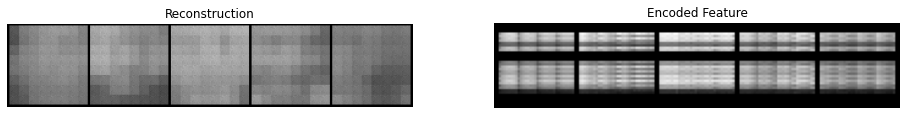

epoch [2/500], loss:0.0120
epoch [3/500], loss:0.0086
epoch [4/500], loss:0.0106
epoch [5/500], loss:0.0100
epoch [6/500], loss:0.0119
epoch [7/500], loss:0.0079
epoch [8/500], loss:0.0066
epoch [9/500], loss:0.0057
epoch [10/500], loss:0.0077
epoch [11/500], loss:0.0067
epoch [12/500], loss:0.0070
epoch [13/500], loss:0.0051
epoch [14/500], loss:0.0059
epoch [15/500], loss:0.0056
epoch [16/500], loss:0.0050
epoch [17/500], loss:0.0070
epoch [18/500], loss:0.0062
epoch [19/500], loss:0.0057
epoch [20/500], loss:0.0035
epoch [21/500], loss:0.0052
epoch [22/500], loss:0.0050
epoch [23/500], loss:0.0052
epoch [24/500], loss:0.0037
epoch [25/500], loss:0.0044
epoch [26/500], loss:0.0044
epoch [27/500], loss:0.0040
epoch [28/500], loss:0.0048
epoch [29/500], loss:0.0039
epoch [30/500], loss:0.0042
epoch [31/500], loss:0.0039
epoch [32/500], loss:0.0052
epoch [33/500], loss:0.0045
epoch [34/500], loss:0.0050
epoch [35/500], loss:0.0033
epoch [36/500], loss:0.0043
epoch [37/500], loss:0.0026


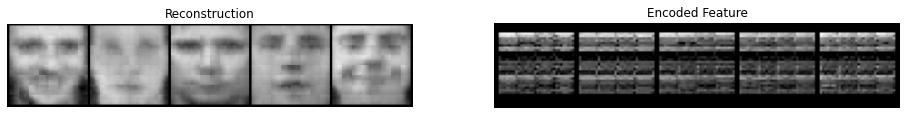

epoch [51/500], loss:0.0038
epoch [52/500], loss:0.0038
epoch [53/500], loss:0.0034
epoch [54/500], loss:0.0027
epoch [55/500], loss:0.0042
epoch [56/500], loss:0.0043
epoch [57/500], loss:0.0034
epoch [58/500], loss:0.0037
epoch [59/500], loss:0.0036
epoch [60/500], loss:0.0033
epoch [61/500], loss:0.0028
epoch [62/500], loss:0.0033
epoch [63/500], loss:0.0036
epoch [64/500], loss:0.0035
epoch [65/500], loss:0.0036
epoch [66/500], loss:0.0042
epoch [67/500], loss:0.0035
epoch [68/500], loss:0.0028
epoch [69/500], loss:0.0038
epoch [70/500], loss:0.0044
epoch [71/500], loss:0.0039
epoch [72/500], loss:0.0040
epoch [73/500], loss:0.0023
epoch [74/500], loss:0.0038
epoch [75/500], loss:0.0047
epoch [76/500], loss:0.0037
epoch [77/500], loss:0.0031
epoch [78/500], loss:0.0038
epoch [79/500], loss:0.0030
epoch [80/500], loss:0.0024
epoch [81/500], loss:0.0027
epoch [82/500], loss:0.0048
epoch [83/500], loss:0.0031
epoch [84/500], loss:0.0032
epoch [85/500], loss:0.0029
epoch [86/500], loss

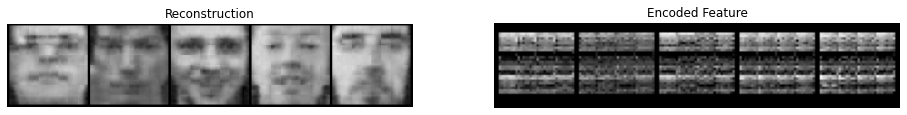

epoch [101/500], loss:0.0031
epoch [102/500], loss:0.0027
epoch [103/500], loss:0.0029
epoch [104/500], loss:0.0031
epoch [105/500], loss:0.0033
epoch [106/500], loss:0.0031
epoch [107/500], loss:0.0024
epoch [108/500], loss:0.0031
epoch [109/500], loss:0.0034
epoch [110/500], loss:0.0035
epoch [111/500], loss:0.0041
epoch [112/500], loss:0.0023
epoch [113/500], loss:0.0047
epoch [114/500], loss:0.0029
epoch [115/500], loss:0.0026
epoch [116/500], loss:0.0032
epoch [117/500], loss:0.0027
epoch [118/500], loss:0.0025
epoch [119/500], loss:0.0029
epoch [120/500], loss:0.0027
epoch [121/500], loss:0.0031
epoch [122/500], loss:0.0035
epoch [123/500], loss:0.0018
epoch [124/500], loss:0.0037
epoch [125/500], loss:0.0028
epoch [126/500], loss:0.0028
epoch [127/500], loss:0.0023
epoch [128/500], loss:0.0024
epoch [129/500], loss:0.0030
epoch [130/500], loss:0.0042
epoch [131/500], loss:0.0034
epoch [132/500], loss:0.0033
epoch [133/500], loss:0.0025
epoch [134/500], loss:0.0021
epoch [135/500

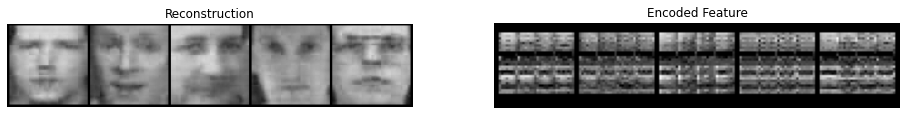

epoch [151/500], loss:0.0037
epoch [152/500], loss:0.0026
epoch [153/500], loss:0.0026
epoch [154/500], loss:0.0039
epoch [155/500], loss:0.0036
epoch [156/500], loss:0.0021
epoch [157/500], loss:0.0022
epoch [158/500], loss:0.0033
epoch [159/500], loss:0.0037
epoch [160/500], loss:0.0018
epoch [161/500], loss:0.0032
epoch [162/500], loss:0.0026
epoch [163/500], loss:0.0031
epoch [164/500], loss:0.0030
epoch [165/500], loss:0.0025
epoch [166/500], loss:0.0027
epoch [167/500], loss:0.0029
epoch [168/500], loss:0.0028
epoch [169/500], loss:0.0030
epoch [170/500], loss:0.0031
epoch [171/500], loss:0.0023
epoch [172/500], loss:0.0037
epoch [173/500], loss:0.0027
epoch [174/500], loss:0.0027
epoch [175/500], loss:0.0022
epoch [176/500], loss:0.0025
epoch [177/500], loss:0.0021
epoch [178/500], loss:0.0022
epoch [179/500], loss:0.0023
epoch [180/500], loss:0.0024
epoch [181/500], loss:0.0019
epoch [182/500], loss:0.0026
epoch [183/500], loss:0.0023
epoch [184/500], loss:0.0036
epoch [185/500

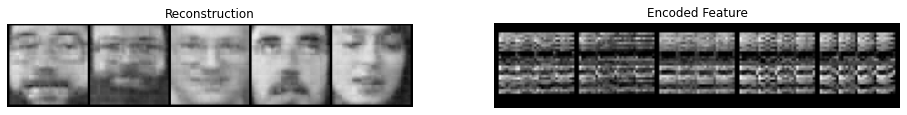

epoch [201/500], loss:0.0016
epoch [202/500], loss:0.0024
epoch [203/500], loss:0.0037
epoch [204/500], loss:0.0028
epoch [205/500], loss:0.0024
epoch [206/500], loss:0.0021
epoch [207/500], loss:0.0020
epoch [208/500], loss:0.0021
epoch [209/500], loss:0.0033
epoch [210/500], loss:0.0024
epoch [211/500], loss:0.0031
epoch [212/500], loss:0.0034
epoch [213/500], loss:0.0027
epoch [214/500], loss:0.0017
epoch [215/500], loss:0.0025
epoch [216/500], loss:0.0021
epoch [217/500], loss:0.0027
epoch [218/500], loss:0.0021
epoch [219/500], loss:0.0036
epoch [220/500], loss:0.0021
epoch [221/500], loss:0.0019
epoch [222/500], loss:0.0033
epoch [223/500], loss:0.0027
epoch [224/500], loss:0.0021
epoch [225/500], loss:0.0014
epoch [226/500], loss:0.0030
epoch [227/500], loss:0.0020
epoch [228/500], loss:0.0024
epoch [229/500], loss:0.0023
epoch [230/500], loss:0.0032
epoch [231/500], loss:0.0020
epoch [232/500], loss:0.0023
epoch [233/500], loss:0.0021
epoch [234/500], loss:0.0022
epoch [235/500

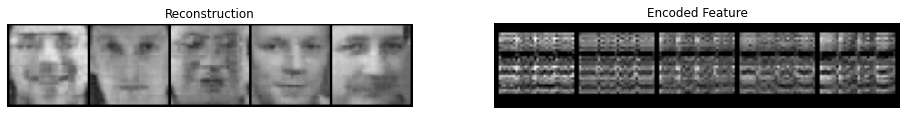

epoch [251/500], loss:0.0026
epoch [252/500], loss:0.0029
epoch [253/500], loss:0.0028
epoch [254/500], loss:0.0017
epoch [255/500], loss:0.0019
epoch [256/500], loss:0.0022
epoch [257/500], loss:0.0017
epoch [258/500], loss:0.0021
epoch [259/500], loss:0.0018
epoch [260/500], loss:0.0023
epoch [261/500], loss:0.0019
epoch [262/500], loss:0.0026
epoch [263/500], loss:0.0020
epoch [264/500], loss:0.0021
epoch [265/500], loss:0.0020
epoch [266/500], loss:0.0025
epoch [267/500], loss:0.0022
epoch [268/500], loss:0.0023
epoch [269/500], loss:0.0021
epoch [270/500], loss:0.0026
epoch [271/500], loss:0.0024
epoch [272/500], loss:0.0027
epoch [273/500], loss:0.0019
epoch [274/500], loss:0.0024
epoch [275/500], loss:0.0020
epoch [276/500], loss:0.0017
epoch [277/500], loss:0.0022
epoch [278/500], loss:0.0021
epoch [279/500], loss:0.0023
epoch [280/500], loss:0.0021
epoch [281/500], loss:0.0017
epoch [282/500], loss:0.0018
epoch [283/500], loss:0.0023
epoch [284/500], loss:0.0015
epoch [285/500

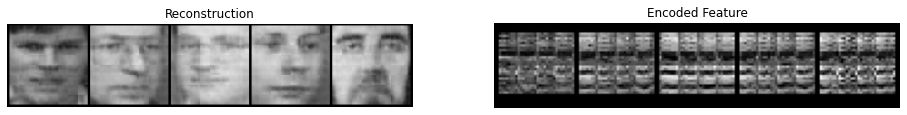

epoch [301/500], loss:0.0029
epoch [302/500], loss:0.0026
epoch [303/500], loss:0.0027
epoch [304/500], loss:0.0024
epoch [305/500], loss:0.0023
epoch [306/500], loss:0.0030
epoch [307/500], loss:0.0016
epoch [308/500], loss:0.0020
epoch [309/500], loss:0.0014
epoch [310/500], loss:0.0017
epoch [311/500], loss:0.0022
epoch [312/500], loss:0.0023
epoch [313/500], loss:0.0023
epoch [314/500], loss:0.0022
epoch [315/500], loss:0.0033
epoch [316/500], loss:0.0019
epoch [317/500], loss:0.0020
epoch [318/500], loss:0.0026
epoch [319/500], loss:0.0019
epoch [320/500], loss:0.0024
epoch [321/500], loss:0.0019
epoch [322/500], loss:0.0019
epoch [323/500], loss:0.0016
epoch [324/500], loss:0.0022
epoch [325/500], loss:0.0023
epoch [326/500], loss:0.0021
epoch [327/500], loss:0.0019
epoch [328/500], loss:0.0023
epoch [329/500], loss:0.0018
epoch [330/500], loss:0.0025
epoch [331/500], loss:0.0023
epoch [332/500], loss:0.0022
epoch [333/500], loss:0.0020
epoch [334/500], loss:0.0022
epoch [335/500

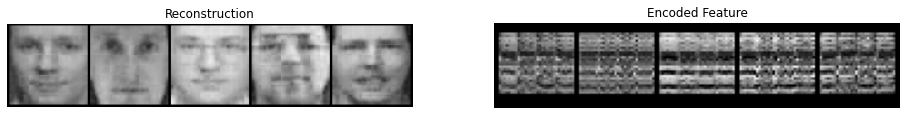

epoch [351/500], loss:0.0027
epoch [352/500], loss:0.0017
epoch [353/500], loss:0.0019
epoch [354/500], loss:0.0027
epoch [355/500], loss:0.0019
epoch [356/500], loss:0.0018
epoch [357/500], loss:0.0015
epoch [358/500], loss:0.0031
epoch [359/500], loss:0.0017
epoch [360/500], loss:0.0021
epoch [361/500], loss:0.0020
epoch [362/500], loss:0.0020
epoch [363/500], loss:0.0021
epoch [364/500], loss:0.0024
epoch [365/500], loss:0.0023
epoch [366/500], loss:0.0018
epoch [367/500], loss:0.0029
epoch [368/500], loss:0.0016
epoch [369/500], loss:0.0025
epoch [370/500], loss:0.0031
epoch [371/500], loss:0.0020
epoch [372/500], loss:0.0019
epoch [373/500], loss:0.0016
epoch [374/500], loss:0.0022
epoch [375/500], loss:0.0024
epoch [376/500], loss:0.0021
epoch [377/500], loss:0.0016
epoch [378/500], loss:0.0022
epoch [379/500], loss:0.0033
epoch [380/500], loss:0.0017
epoch [381/500], loss:0.0025
epoch [382/500], loss:0.0025
epoch [383/500], loss:0.0025
epoch [384/500], loss:0.0021
epoch [385/500

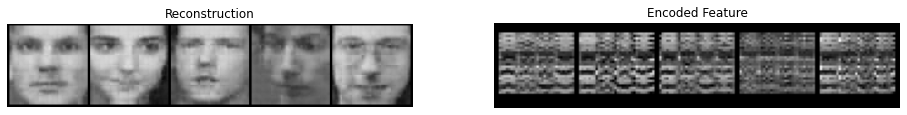

epoch [401/500], loss:0.0022
epoch [402/500], loss:0.0026
epoch [403/500], loss:0.0031
epoch [404/500], loss:0.0025
epoch [405/500], loss:0.0020
epoch [406/500], loss:0.0020
epoch [407/500], loss:0.0020
epoch [408/500], loss:0.0026
epoch [409/500], loss:0.0028
epoch [410/500], loss:0.0027
epoch [411/500], loss:0.0029
epoch [412/500], loss:0.0019
epoch [413/500], loss:0.0019
epoch [414/500], loss:0.0020
epoch [415/500], loss:0.0015
epoch [416/500], loss:0.0023
epoch [417/500], loss:0.0015
epoch [418/500], loss:0.0017
epoch [419/500], loss:0.0018
epoch [420/500], loss:0.0019
epoch [421/500], loss:0.0025
epoch [422/500], loss:0.0018
epoch [423/500], loss:0.0022
epoch [424/500], loss:0.0022
epoch [425/500], loss:0.0021
epoch [426/500], loss:0.0021
epoch [427/500], loss:0.0028
epoch [428/500], loss:0.0030
epoch [429/500], loss:0.0022
epoch [430/500], loss:0.0024
epoch [431/500], loss:0.0031
epoch [432/500], loss:0.0021
epoch [433/500], loss:0.0018
epoch [434/500], loss:0.0018
epoch [435/500

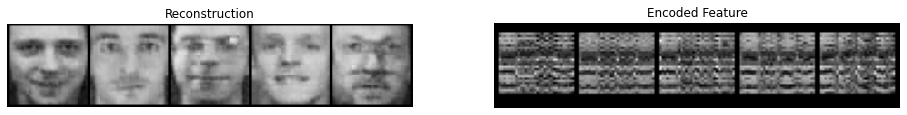

epoch [451/500], loss:0.0024
epoch [452/500], loss:0.0024
epoch [453/500], loss:0.0017
epoch [454/500], loss:0.0012
epoch [455/500], loss:0.0019
epoch [456/500], loss:0.0022
epoch [457/500], loss:0.0021
epoch [458/500], loss:0.0027
epoch [459/500], loss:0.0026
epoch [460/500], loss:0.0019
epoch [461/500], loss:0.0017
epoch [462/500], loss:0.0020
epoch [463/500], loss:0.0024
epoch [464/500], loss:0.0022
epoch [465/500], loss:0.0032
epoch [466/500], loss:0.0022
epoch [467/500], loss:0.0017
epoch [468/500], loss:0.0015
epoch [469/500], loss:0.0016
epoch [470/500], loss:0.0019
epoch [471/500], loss:0.0017
epoch [472/500], loss:0.0019
epoch [473/500], loss:0.0022
epoch [474/500], loss:0.0026
epoch [475/500], loss:0.0023
epoch [476/500], loss:0.0023
epoch [477/500], loss:0.0022
epoch [478/500], loss:0.0019
epoch [479/500], loss:0.0028
epoch [480/500], loss:0.0019
epoch [481/500], loss:0.0027
epoch [482/500], loss:0.0014
epoch [483/500], loss:0.0018
epoch [484/500], loss:0.0026
epoch [485/500

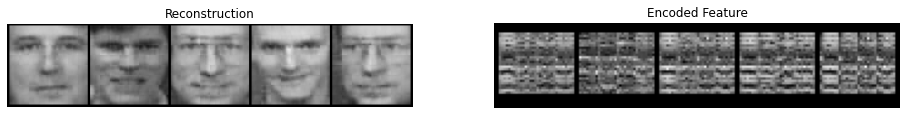

Finished.


In [29]:
# define the folder to save the visualization pictures
if not os.path.exists('./face_vis'):
    os.mkdir('./face_vis')
    os.mkdir('./face_vis/reconstruction/')
    os.mkdir('./face_vis/feature/')

#define the hyper-parameters
num_epochs = 500
batch_size = 5
learning_rate = 1e-3

# load the dataset
faces = fetch_olivetti_faces().data
faces.resize((faces.shape[0],1, 64, 64))
dataset = torch.from_numpy(faces)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#  try different values of d in the feature dimension
d = 16

# define a model and criterion
model = autoencoder_face(d)
### CODE HERE ###
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img = data
        # ===================forward=====================
        ### CODE HERE ###
        output,feature = model.forward(img)
        loss = criterion(output, img)
        
        # ===================backward====================
        ### CODE HERE ###
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # log
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss))
    if epoch==0 or (epoch+1) % 50 == 0:
        pic_output = output
        save_image(pic_output, './face_vis/reconstruction/output_{}.png'.format(epoch+1))
        
        pic_feature = feature.view(feature.size(0), 1, d*2, -1)
        save_image(pic_feature, './face_vis/feature/feature_{}.png'.format(epoch+1), normalize=True)
        
        # visualization
        img1 = mpimg.imread('./face_vis/reconstruction/output_{}.png'.format(epoch+1))
        img2 = mpimg.imread('./face_vis/feature/feature_{}.png'.format(epoch+1))
        
        fig = plt.figure(figsize=(16, 4))
        plt.subplot(121).set_title('Reconstruction')
        plt.imshow(img1)
        plt.axis('off')
        plt.subplot(122).set_title('Encoded Feature')
        plt.imshow(img2)
        plt.axis('off')
        plt.show()

# save the trained network
torch.save(model.state_dict(), './conv_autoencoder_face.pth')
print('Finished.')

Now you can play with 'd' in PCA and the autoencoder to compare the reconstruction from PCA-eigenfaces with it from the autoencoder. 

**Question:** Should encoder and decoder have similar architecture?
